# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [30]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dex     3690 non-null   float64
 1   cha     3690 non-null   float64
 2   ac      3690 non-null   float64
 3   int     3690 non-null   float64
 4   str     3690 non-null   float64
 5   book    3690 non-null   object 
 6   hp      3690 non-null   int64  
 7   level   3690 non-null   int64  
 8   wis     3690 non-null   float64
 9   con     3690 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 317.1+ KB


In [32]:
df.head()

,dex,cha,ac,int,str,book,hp,level,wis,con
0,3.0,0.0,28.0,0.0,6.0,Pathfinder #165: Eyes of Empty Death,155,9,3.0,0.0
1,3.0,0.0,30.0,0.0,7.0,Pathfinder Abomination Vaults Hardcover Compil...,175,10,3.0,6.0
2,3.0,1.0,17.0,-2.0,4.0,Pathfinder #164: Hands of the Devil,38,2,3.0,1.0
3,4.0,1.0,27.0,0.0,3.0,Pathfinder #164: Hands of the Devil,140,8,3.0,3.0
4,6.0,2.0,31.0,2.0,-5.0,Pathfinder #165: Eyes of Empty Death,90,9,4.0,0.0


###### Level

In [33]:
y = df["level"]
y

0        9
1       10
2        2
3        8
4        9
        ..
4322     2
4324     3
4325     4
4326     2
4327     2
Name: level, Length: 3690, dtype: int64

In [34]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [35]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,147
1,0,87
2,1,320
3,2,335
4,3,339
5,4,274
6,5,268
7,6,220
8,7,215
9,8,188


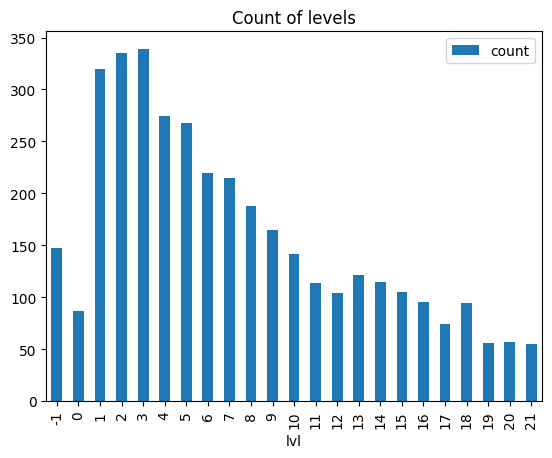

In [36]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [37]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [38]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [39]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [40]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [41]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 1626, number of used features: 8
[LightGBM] [Info] Start training from score 7.212177
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.447891	valid_0's l2: 0.575491


In [42]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.76
MAE: 0.45


In [44]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [45]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.76


###### MAE by level

In [46]:
from training.results import plot_mae_by_level

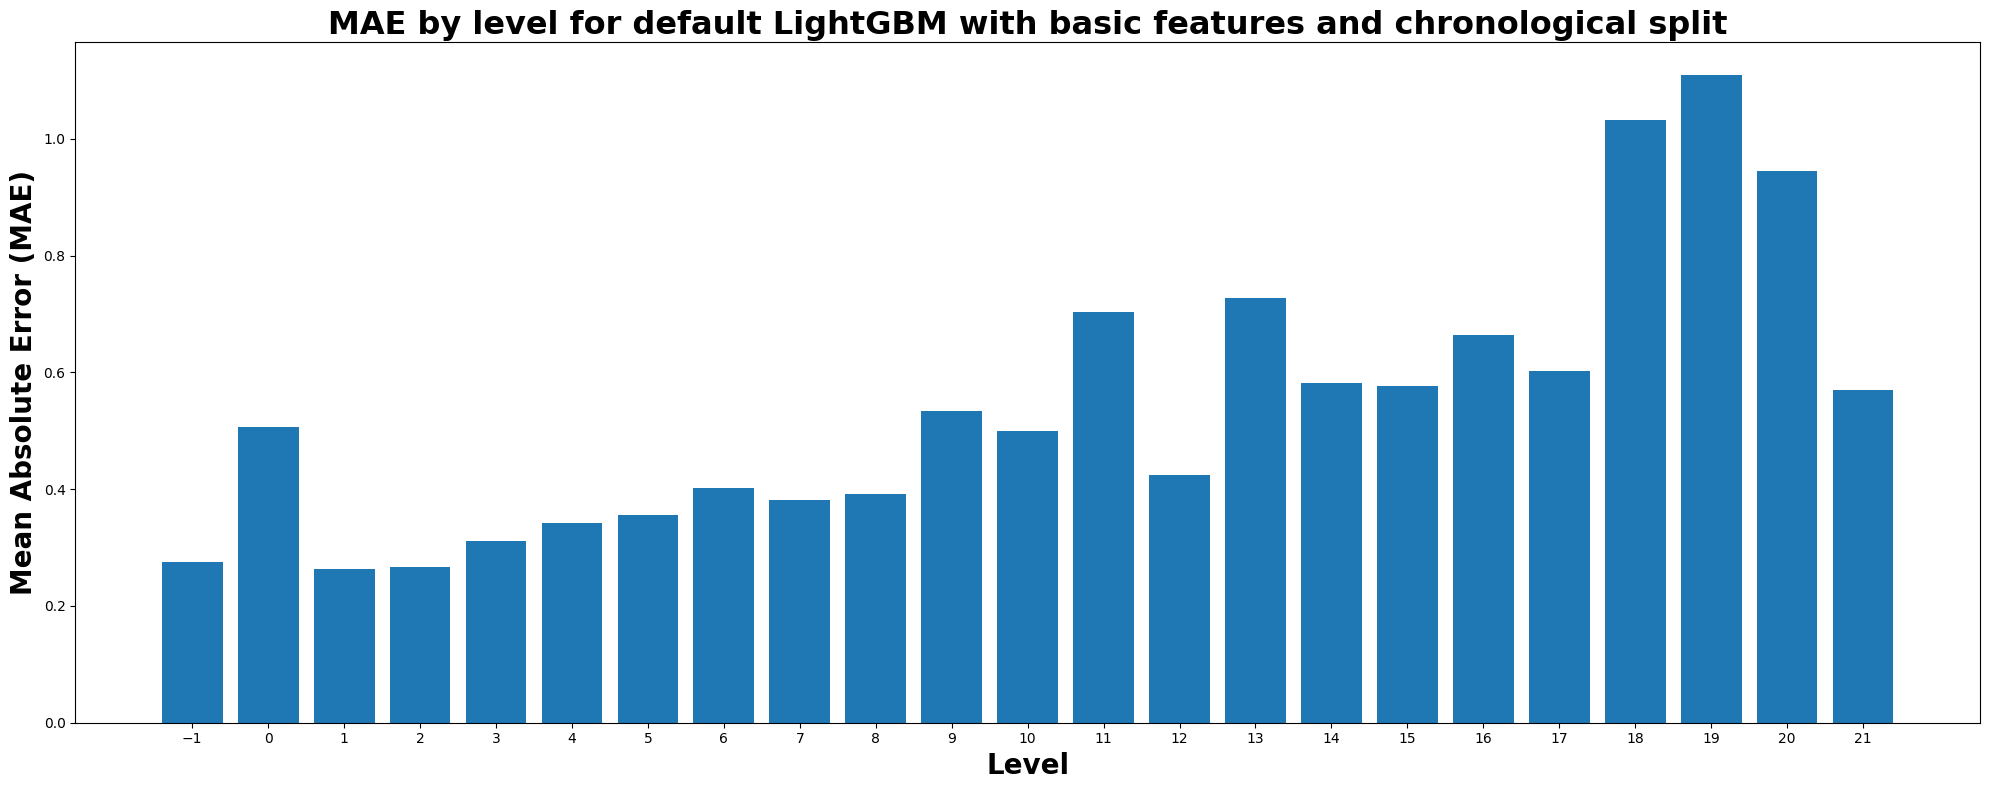

In [47]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [48]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.76

Round type: 0.5
RMSE: 0.78

Round type: 0.33
RMSE: 0.77

Round type: 0.45
RMSE: 0.77



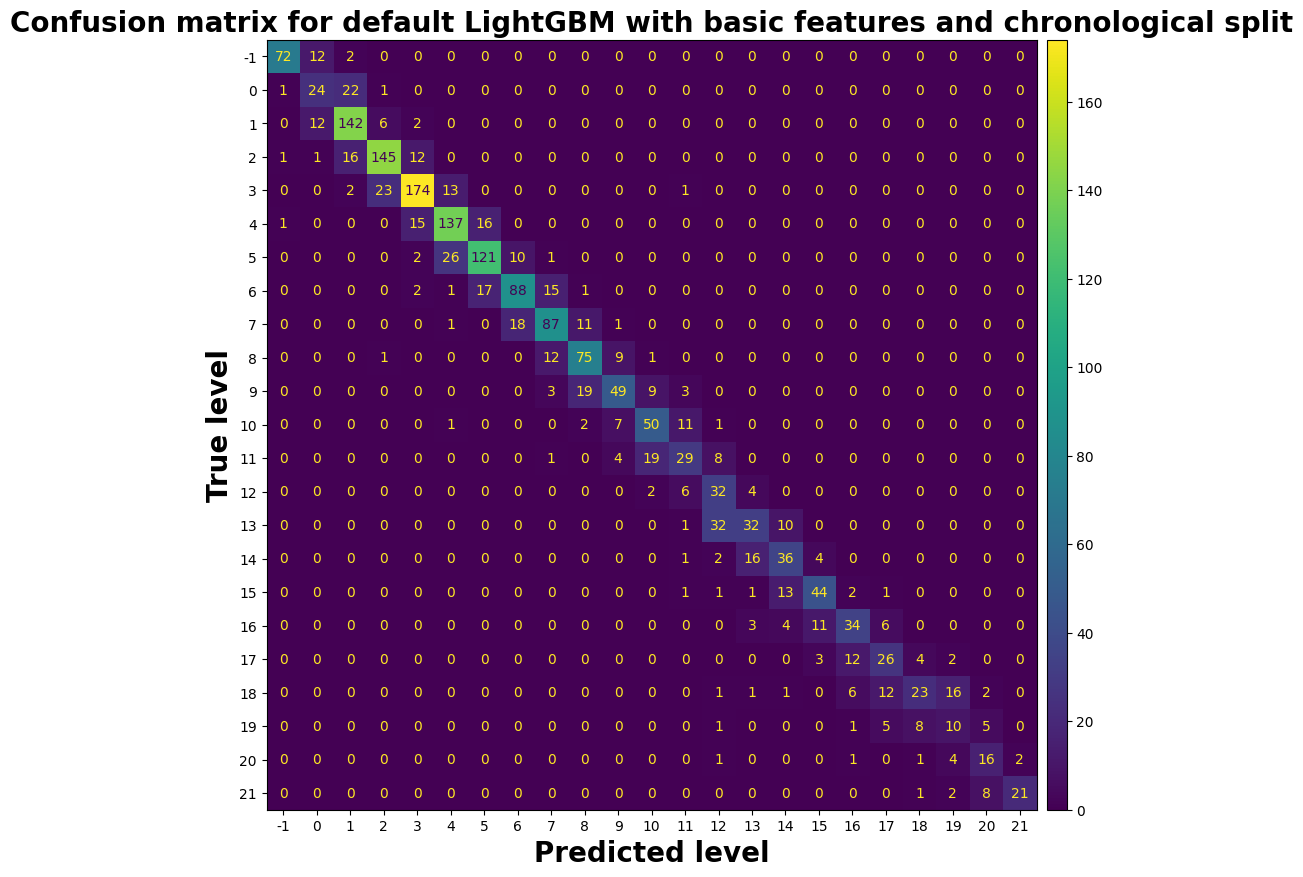

In [49]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [50]:
from training.results import assess_regression_model

In [51]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-26 22:27:27,167] A new study created in memory with name: no-name-2f7746bb-8312-41ea-ab79-5fa625a40982
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.285266 + 0.150867


feature_fraction, val_score: 0.285025:  14%|#4        | 1/7 [00:01<00:06,  1.01s/it]

Early stopping, best iteration is:
[96]	cv_agg's l2: 0.285025 + 0.150184
[100]	cv_agg's l2: 0.316485 + 0.139686


feature_fraction, val_score: 0.285025:  29%|##8       | 2/7 [00:02<00:05,  1.04s/it]

Early stopping, best iteration is:
[96]	cv_agg's l2: 0.285025 + 0.150184
[100]	cv_agg's l2: 0.284216 + 0.14205


feature_fraction, val_score: 0.283506:  43%|####2     | 3/7 [00:03<00:04,  1.08s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.283506 + 0.142763
[100]	cv_agg's l2: 0.467382 + 0.305933


feature_fraction, val_score: 0.283506:  57%|#####7    | 4/7 [00:04<00:03,  1.28s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.283506 + 0.142763
[100]	cv_agg's l2: 0.2902 + 0.141111


feature_fraction, val_score: 0.283506:  71%|#######1  | 5/7 [00:05<00:02,  1.14s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.283506 + 0.142763
[100]	cv_agg's l2: 0.281018 + 0.138393


feature_fraction, val_score: 0.281000:  86%|########5 | 6/7 [00:06<00:01,  1.14s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.281 + 0.138343
[100]	cv_agg's l2: 0.284216 + 0.14205


feature_fraction, val_score: 0.281000: 100%|##########| 7/7 [00:07<00:00,  1.12s/it]


Early stopping, best iteration is:
[99]	cv_agg's l2: 0.281 + 0.138343


num_leaves, val_score: 0.281000:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.282894 + 0.132704


num_leaves, val_score: 0.281000:   5%|5         | 1/20 [00:01<00:34,  1.84s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.281 + 0.138343
[100]	cv_agg's l2: 0.282894 + 0.132704


num_leaves, val_score: 0.281000:  10%|#         | 2/20 [00:04<00:37,  2.08s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.281 + 0.138343
[100]	cv_agg's l2: 0.282894 + 0.132704


num_leaves, val_score: 0.281000:  15%|#5        | 3/20 [00:06<00:39,  2.35s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.281 + 0.138343
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198


num_leaves, val_score: 0.271147:  20%|##        | 4/20 [00:07<00:27,  1.74s/it]

[100]	cv_agg's l2: 0.272018 + 0.134567
[200]	cv_agg's l2: 0.27726 + 0.133458


num_leaves, val_score: 0.271147:  25%|##5       | 5/20 [00:09<00:25,  1.70s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.395334 + 0.160641


num_leaves, val_score: 0.271147:  30%|###       | 6/20 [00:09<00:17,  1.23s/it]

[200]	cv_agg's l2: 0.35845 + 0.150939
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.284539 + 0.134163


num_leaves, val_score: 0.271147:  35%|###5      | 7/20 [00:10<00:14,  1.08s/it]

[200]	cv_agg's l2: 0.280591 + 0.131922
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198


[I 2023-11-26 22:27:45,348] Trial 13 finished with value: 0.279979759630984 and parameters: {'num_leaves': 9}. Best is trial 10 with value: 0.2711470029569957.
num_leaves, val_score: 0.271147:  35%|###5      | 7/20 [00:10<00:14,  1.08s/it]

[100]	cv_agg's l2: 0.282894 + 0.132704
[200]	cv_agg's l2: 0.292376 + 0.133558


num_leaves, val_score: 0.271147:  40%|####      | 8/20 [00:14<00:23,  1.95s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.283249 + 0.132069
[200]	cv_agg's l2: 0.291764 + 0.133833


num_leaves, val_score: 0.271147:  45%|####5     | 9/20 [00:17<00:28,  2.56s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282894 + 0.132704
[200]	cv_agg's l2: 0.292376 + 0.133558


num_leaves, val_score: 0.271147:  50%|#####     | 10/20 [00:22<00:32,  3.30s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282894 + 0.132704
[200]	cv_agg's l2: 0.292376 + 0.133558


num_leaves, val_score: 0.271147:  55%|#####5    | 11/20 [00:29<00:38,  4.22s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282025 + 0.137684
[200]	cv_agg's l2: 0.289607 + 0.139648


num_leaves, val_score: 0.271147:  60%|######    | 12/20 [00:32<00:30,  3.86s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.283546 + 0.137005
[200]	cv_agg's l2: 0.292072 + 0.139091


num_leaves, val_score: 0.271147:  65%|######5   | 13/20 [00:35<00:26,  3.80s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282894 + 0.132704
[200]	cv_agg's l2: 0.292376 + 0.133558


num_leaves, val_score: 0.271147:  70%|#######   | 14/20 [00:40<00:23,  3.88s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.395334 + 0.160641


num_leaves, val_score: 0.271147:  75%|#######5  | 15/20 [00:40<00:14,  2.83s/it]

[200]	cv_agg's l2: 0.35845 + 0.150939
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.395334 + 0.160641
[200]	cv_agg's l2: 0.35845 + 0.150939


num_leaves, val_score: 0.271147:  80%|########  | 16/20 [00:40<00:08,  2.09s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282894 + 0.132704
[200]	cv_agg's l2: 0.292376 + 0.133558


num_leaves, val_score: 0.271147:  85%|########5 | 17/20 [00:44<00:07,  2.55s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.27838 + 0.137231
[200]	cv_agg's l2: 0.284012 + 0.13563


num_leaves, val_score: 0.271147:  90%|######### | 18/20 [00:46<00:04,  2.44s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282894 + 0.132704
[200]	cv_agg's l2: 0.292376 + 0.133558


num_leaves, val_score: 0.271147:  95%|#########5| 19/20 [00:51<00:03,  3.04s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282428 + 0.141524
[200]	cv_agg's l2: 0.291575 + 0.143131


num_leaves, val_score: 0.271147: 100%|##########| 20/20 [00:53<00:00,  2.66s/it]


Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198


bagging, val_score: 0.271147:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.280162 + 0.133736
[200]	cv_agg's l2: 0.274041 + 0.132685


bagging, val_score: 0.271147:  10%|#         | 1/10 [00:01<00:10,  1.16s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.279159 + 0.132828
[200]	cv_agg's l2: 0.27651 + 0.133505


bagging, val_score: 0.271147:  20%|##        | 2/10 [00:02<00:09,  1.20s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.281278 + 0.131108
[200]	cv_agg's l2: 0.277902 + 0.130756


bagging, val_score: 0.271147:  30%|###       | 3/10 [00:03<00:08,  1.17s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.312219 + 0.132538
[200]	cv_agg's l2: 0.308473 + 0.124097


bagging, val_score: 0.271147:  40%|####      | 4/10 [00:04<00:06,  1.16s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.277592 + 0.127754
[200]	cv_agg's l2: 0.275255 + 0.127999


bagging, val_score: 0.271147:  50%|#####     | 5/10 [00:05<00:05,  1.19s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


bagging, val_score: 0.271147:  60%|######    | 6/10 [00:07<00:04,  1.21s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.27846 + 0.131219
[200]	cv_agg's l2: 0.276404 + 0.131411


bagging, val_score: 0.271147:  70%|#######   | 7/10 [00:08<00:03,  1.22s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.279287 + 0.129787
[200]	cv_agg's l2: 0.275853 + 0.127328


bagging, val_score: 0.271147:  80%|########  | 8/10 [00:10<00:02,  1.49s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275624 + 0.128773
[200]	cv_agg's l2: 0.272812 + 0.129062


bagging, val_score: 0.271147:  90%|######### | 9/10 [00:11<00:01,  1.42s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.286236 + 0.132693
[200]	cv_agg's l2: 0.277373 + 0.130362


bagging, val_score: 0.271147: 100%|##########| 10/10 [00:12<00:00,  1.29s/it]


Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198


feature_fraction_stage2, val_score: 0.271147:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


feature_fraction_stage2, val_score: 0.271147:  17%|#6        | 1/6 [00:01<00:05,  1.12s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.279834 + 0.130005
[200]	cv_agg's l2: 0.276643 + 0.129266


feature_fraction_stage2, val_score: 0.271147:  33%|###3      | 2/6 [00:02<00:04,  1.15s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.279834 + 0.130005
[200]	cv_agg's l2: 0.276643 + 0.129266


feature_fraction_stage2, val_score: 0.271147:  50%|#####     | 3/6 [00:03<00:03,  1.16s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


feature_fraction_stage2, val_score: 0.271147:  67%|######6   | 4/6 [00:04<00:02,  1.14s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


feature_fraction_stage2, val_score: 0.271147:  83%|########3 | 5/6 [00:05<00:01,  1.13s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


feature_fraction_stage2, val_score: 0.271147: 100%|##########| 6/6 [00:07<00:00,  1.28s/it]


Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198


regularization_factors, val_score: 0.271147:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.275766 + 0.130653
[200]	cv_agg's l2: 0.27444 + 0.131521


regularization_factors, val_score: 0.271147:   5%|5         | 1/20 [00:01<00:36,  1.91s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275563 + 0.130223
[200]	cv_agg's l2: 0.273163 + 0.129411


regularization_factors, val_score: 0.271147:  10%|#         | 2/20 [00:03<00:33,  1.88s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.306314 + 0.13734
[200]	cv_agg's l2: 0.301015 + 0.135339


regularization_factors, val_score: 0.271147:  15%|#5        | 3/20 [00:05<00:30,  1.78s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


regularization_factors, val_score: 0.271147:  20%|##        | 4/20 [00:07<00:29,  1.87s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.276647 + 0.130264
[200]	cv_agg's l2: 0.275695 + 0.129928


regularization_factors, val_score: 0.271147:  25%|##5       | 5/20 [00:09<00:28,  1.90s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


regularization_factors, val_score: 0.271147:  30%|###       | 6/20 [00:11<00:26,  1.92s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.277375 + 0.129264
[200]	cv_agg's l2: 0.274438 + 0.129745


regularization_factors, val_score: 0.271147:  35%|###5      | 7/20 [00:13<00:26,  2.03s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.293406 + 0.134195


regularization_factors, val_score: 0.271147:  40%|####      | 8/20 [00:15<00:22,  1.87s/it]

[200]	cv_agg's l2: 0.290003 + 0.133325
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.280579 + 0.130297
[200]	cv_agg's l2: 0.278633 + 0.13195


regularization_factors, val_score: 0.271147:  45%|####5     | 9/20 [00:17<00:21,  1.95s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.281835 + 0.128105
[200]	cv_agg's l2: 0.279044 + 0.130446


regularization_factors, val_score: 0.271147:  50%|#####     | 10/20 [00:19<00:19,  1.97s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


regularization_factors, val_score: 0.271147:  55%|#####5    | 11/20 [00:21<00:17,  1.97s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273581 + 0.126028


regularization_factors, val_score: 0.271147:  60%|######    | 12/20 [00:23<00:15,  1.95s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273193 + 0.126342


regularization_factors, val_score: 0.271147:  65%|######5   | 13/20 [00:25<00:13,  1.97s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275406 + 0.127552
[200]	cv_agg's l2: 0.272792 + 0.126476


regularization_factors, val_score: 0.271147:  70%|#######   | 14/20 [00:27<00:12,  2.00s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.277554 + 0.129625
[200]	cv_agg's l2: 0.274463 + 0.130791


regularization_factors, val_score: 0.271147:  75%|#######5  | 15/20 [00:29<00:10,  2.02s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273581 + 0.126028


regularization_factors, val_score: 0.271147:  80%|########  | 16/20 [00:31<00:08,  2.01s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.282569 + 0.136174
[200]	cv_agg's l2: 0.276293 + 0.136289


regularization_factors, val_score: 0.271147:  85%|########5 | 17/20 [00:33<00:05,  1.99s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275405 + 0.127552
[200]	cv_agg's l2: 0.272793 + 0.126476


regularization_factors, val_score: 0.271147:  90%|######### | 18/20 [00:35<00:03,  1.98s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


regularization_factors, val_score: 0.271147:  95%|#########5| 19/20 [00:37<00:01,  1.99s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.275234 + 0.127685
[200]	cv_agg's l2: 0.273284 + 0.126268


regularization_factors, val_score: 0.271147: 100%|##########| 20/20 [00:39<00:00,  1.96s/it]


Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198


min_data_in_leaf, val_score: 0.271147:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.313001 + 0.135239
[200]	cv_agg's l2: 0.308594 + 0.131638


min_data_in_leaf, val_score: 0.271147:  20%|##        | 1/5 [00:01<00:07,  1.95s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.278424 + 0.123567
[200]	cv_agg's l2: 0.280106 + 0.122213


min_data_in_leaf, val_score: 0.271147:  40%|####      | 2/5 [00:03<00:05,  1.96s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.278631 + 0.126643
[200]	cv_agg's l2: 0.277914 + 0.125192


min_data_in_leaf, val_score: 0.271147:  60%|######    | 3/5 [00:05<00:03,  1.97s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.449253 + 0.201028
[200]	cv_agg's l2: 0.445603 + 0.207189


min_data_in_leaf, val_score: 0.271147:  80%|########  | 4/5 [00:07<00:01,  1.88s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198
[100]	cv_agg's l2: 0.28302 + 0.131536
[200]	cv_agg's l2: 0.277377 + 0.132797


min_data_in_leaf, val_score: 0.271147: 100%|##########| 5/5 [00:09<00:00,  1.90s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.271147 + 0.126198


In [52]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.2711470029569957
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 11
    feature_fraction: 0.8999999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [53]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [54]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.02
RMSE test: 0.75
MAE test: 0.46



In [55]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

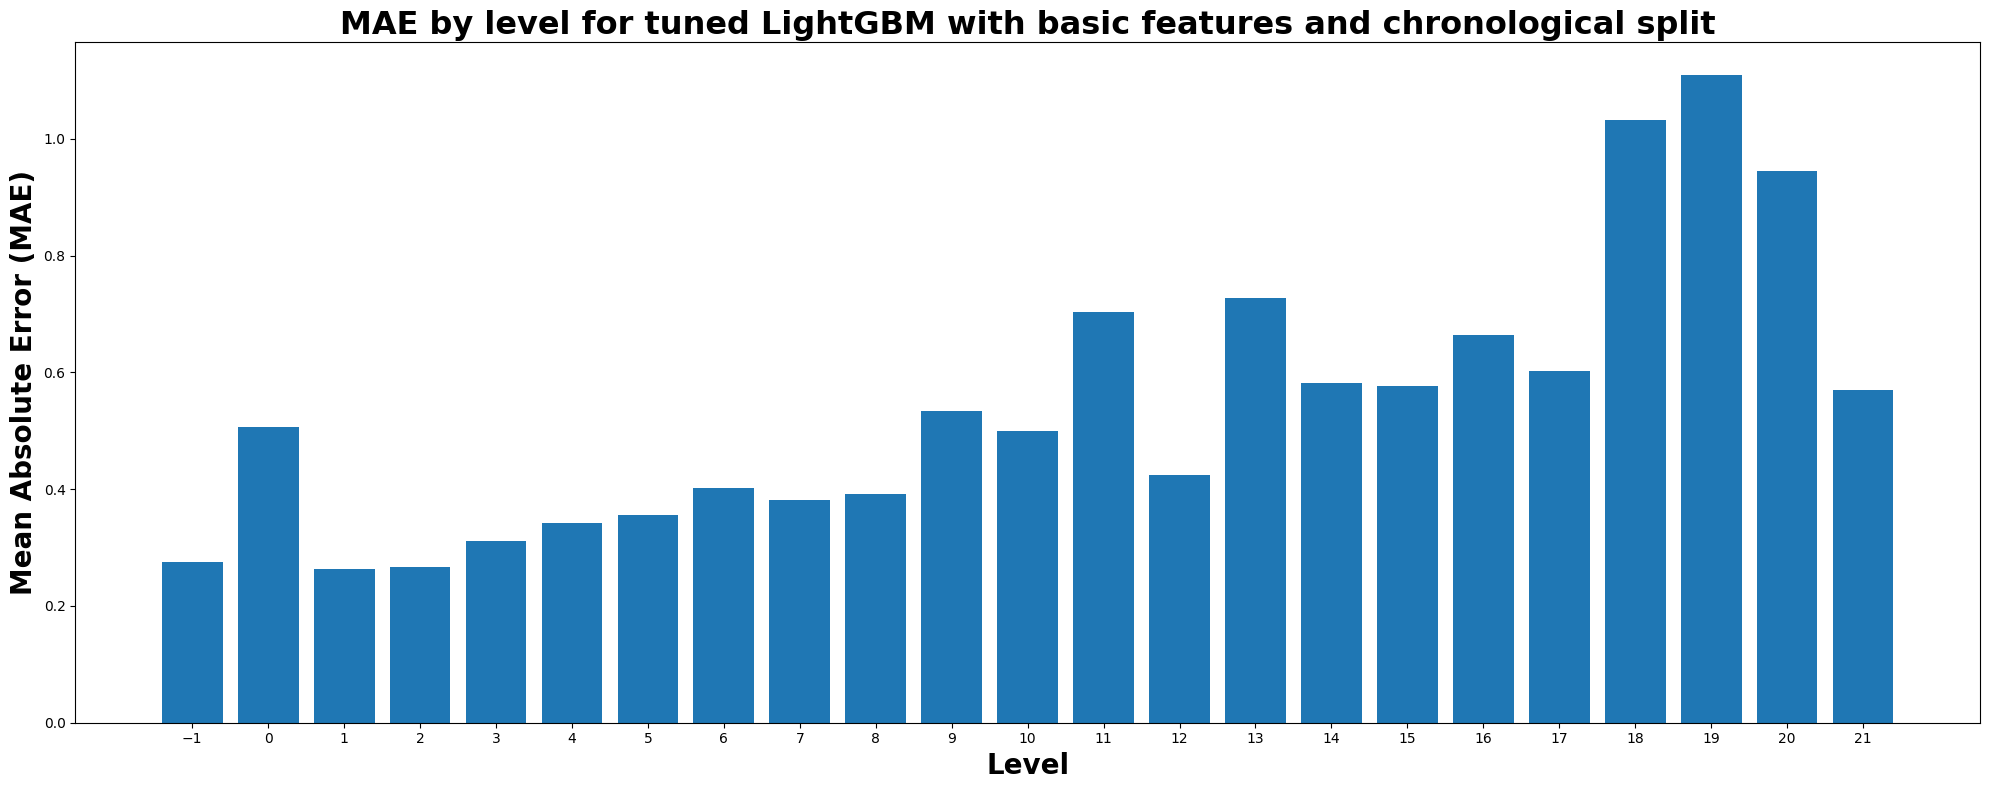

In [56]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [57]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.75

Round type: 0.5
RMSE: 0.78

Round type: 0.33
RMSE: 0.78

Round type: 0.45
RMSE: 0.78



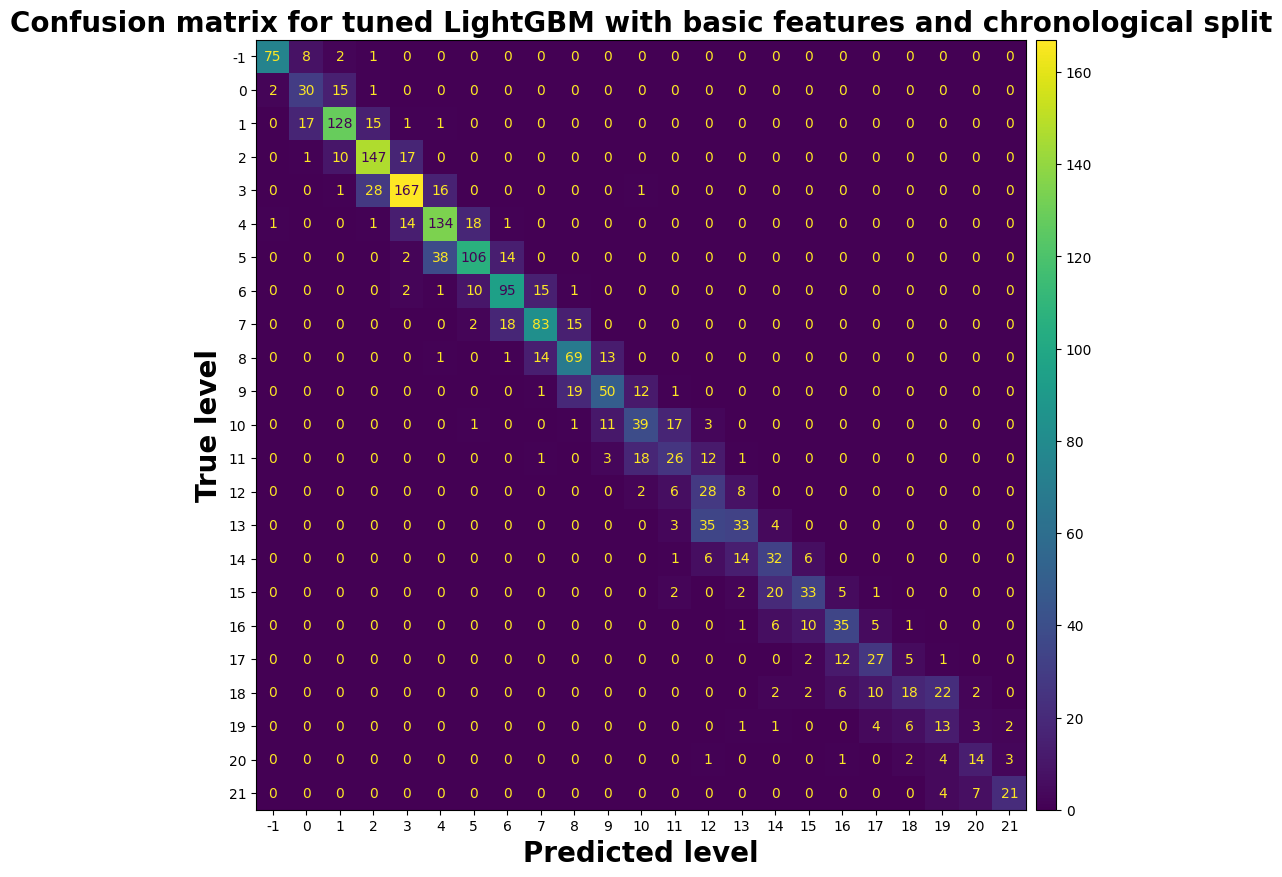

In [58]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [59]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 2767, number of used features: 8
[LightGBM] [Info] Start training from score 7.220455
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's l1: 0.368391	valid_0's l2: 0.322742


In [60]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.57
MAE: 0.37


In [62]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

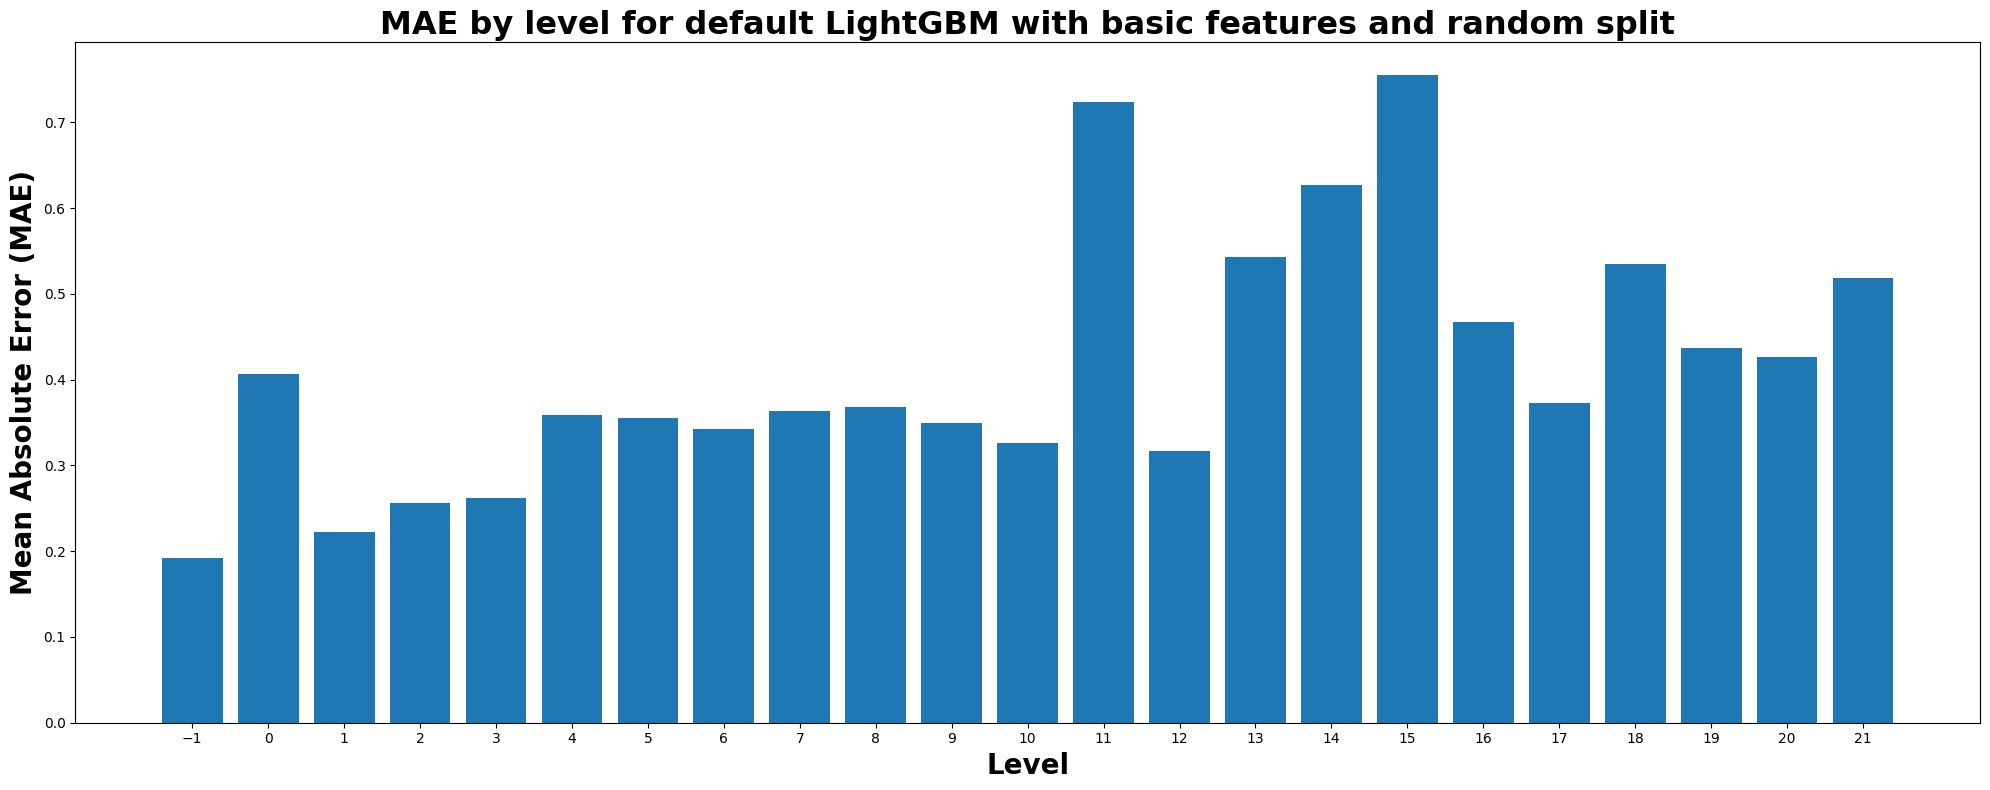

In [63]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [64]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.57

Round type: 0.5
RMSE: 0.60

Round type: 0.33
RMSE: 0.64

Round type: 0.45
RMSE: 0.60



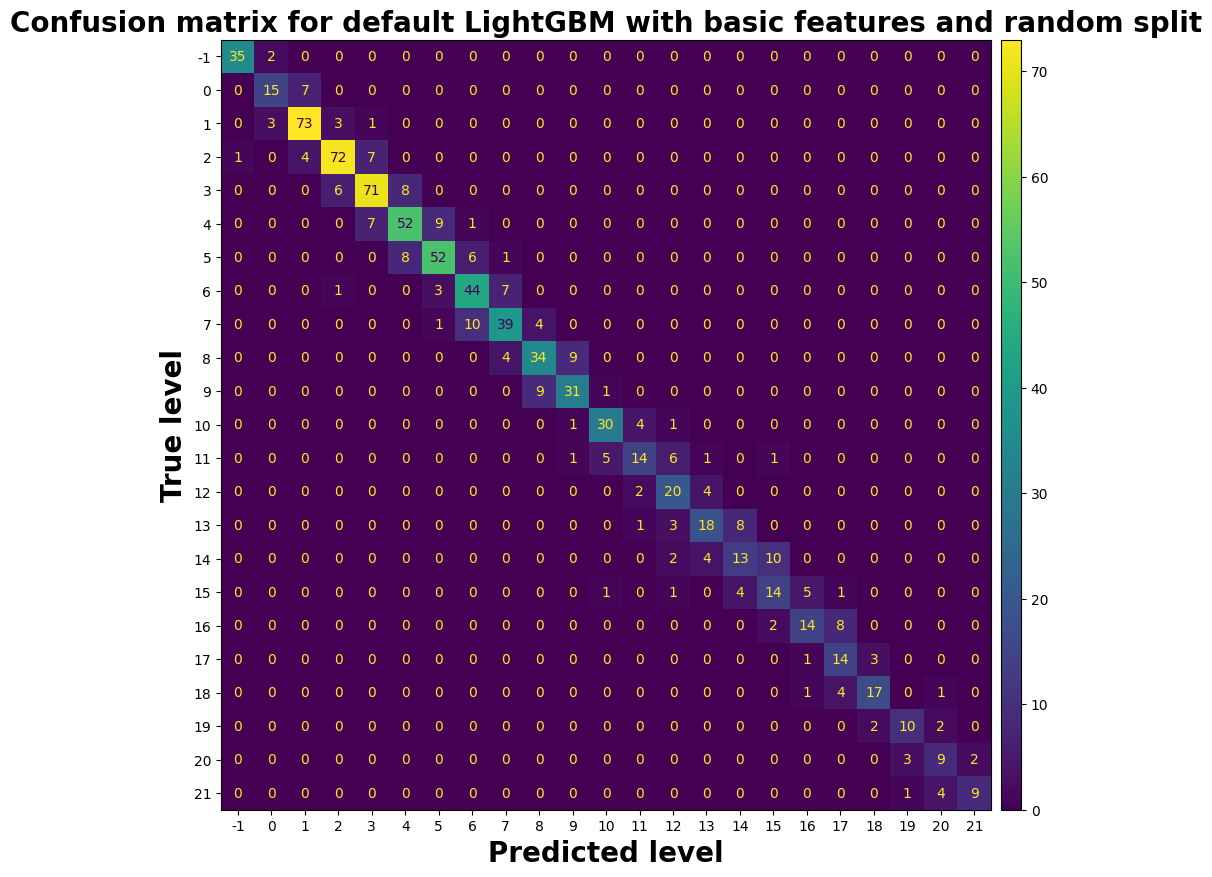

In [65]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [66]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-26 22:30:05,936] A new study created in memory with name: no-name-582368bc-1fbc-4067-8241-7ccb4400dc79
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.400613 + 0.0945312
[200]	cv_agg's l2: 0.384753 + 0.0894388
[300]	cv_agg's l2: 0.38257 + 0.0868304
[400]	cv_agg's l2: 0.383241 + 0.0843991


feature_fraction, val_score: 0.382100:  14%|#4        | 1/7 [00:07<00:46,  7.83s/it]

Early stopping, best iteration is:
[361]	cv_agg's l2: 0.3821 + 0.084783
[100]	cv_agg's l2: 0.38949 + 0.118419
[200]	cv_agg's l2: 0.388619 + 0.116672
[300]	cv_agg's l2: 0.392941 + 0.114251
[400]	cv_agg's l2: 0.394061 + 0.112228


feature_fraction, val_score: 0.382100:  29%|##8       | 2/7 [00:15<00:38,  7.75s/it]

Early stopping, best iteration is:
[361]	cv_agg's l2: 0.3821 + 0.084783
[100]	cv_agg's l2: 0.38949 + 0.118419
[200]	cv_agg's l2: 0.388619 + 0.116672
[300]	cv_agg's l2: 0.392941 + 0.114251
[400]	cv_agg's l2: 0.394061 + 0.112228


feature_fraction, val_score: 0.382100:  43%|####2     | 3/7 [00:23<00:31,  7.78s/it]

Early stopping, best iteration is:
[361]	cv_agg's l2: 0.3821 + 0.084783
[100]	cv_agg's l2: 0.467809 + 0.0748572
[200]	cv_agg's l2: 0.429304 + 0.0801077
[300]	cv_agg's l2: 0.424112 + 0.079523
[400]	cv_agg's l2: 0.422797 + 0.0793565


feature_fraction, val_score: 0.382100:  57%|#####7    | 4/7 [00:31<00:23,  7.81s/it]

Early stopping, best iteration is:
[361]	cv_agg's l2: 0.3821 + 0.084783
[100]	cv_agg's l2: 0.381762 + 0.104931
[200]	cv_agg's l2: 0.382444 + 0.102113


feature_fraction, val_score: 0.379045:  71%|#######1  | 5/7 [00:35<00:12,  6.44s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.379045 + 0.103411
[100]	cv_agg's l2: 0.394264 + 0.116915
[200]	cv_agg's l2: 0.393666 + 0.110216


feature_fraction, val_score: 0.379045:  86%|########5 | 6/7 [00:39<00:05,  5.65s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.379045 + 0.103411
[100]	cv_agg's l2: 0.395796 + 0.116656
[200]	cv_agg's l2: 0.395382 + 0.114804


feature_fraction, val_score: 0.379045: 100%|##########| 7/7 [00:43<00:00,  6.20s/it]


Early stopping, best iteration is:
[142]	cv_agg's l2: 0.379045 + 0.103411


num_leaves, val_score: 0.379045:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


num_leaves, val_score: 0.371391:   5%|5         | 1/20 [00:05<01:35,  5.03s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.379361 + 0.107676
[200]	cv_agg's l2: 0.382919 + 0.105233


num_leaves, val_score: 0.371391:  10%|#         | 2/20 [00:14<02:14,  7.46s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.379361 + 0.107676
[200]	cv_agg's l2: 0.382919 + 0.105233


num_leaves, val_score: 0.371391:  15%|#5        | 3/20 [00:23<02:19,  8.19s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.385514 + 0.100603
[200]	cv_agg's l2: 0.374518 + 0.0963321


num_leaves, val_score: 0.371391:  20%|##        | 4/20 [00:25<01:32,  5.75s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.382418 + 0.105085
[200]	cv_agg's l2: 0.384592 + 0.105764


num_leaves, val_score: 0.371391:  25%|##5       | 5/20 [00:32<01:32,  6.19s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.379361 + 0.107676
[200]	cv_agg's l2: 0.382919 + 0.105233


num_leaves, val_score: 0.371391:  30%|###       | 6/20 [00:41<01:38,  7.06s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.379361 + 0.107676
[200]	cv_agg's l2: 0.382919 + 0.105233


num_leaves, val_score: 0.371391:  35%|###5      | 7/20 [00:50<01:42,  7.85s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.379361 + 0.107676
[200]	cv_agg's l2: 0.382919 + 0.105233


num_leaves, val_score: 0.371391:  40%|####      | 8/20 [00:59<01:37,  8.15s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.400043 + 0.10433
[200]	cv_agg's l2: 0.381621 + 0.0980971
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288


num_leaves, val_score: 0.371391:  45%|####5     | 9/20 [01:00<01:07,  6.12s/it]

[100]	cv_agg's l2: 0.382737 + 0.107361
[200]	cv_agg's l2: 0.387749 + 0.107831


num_leaves, val_score: 0.371391:  50%|#####     | 10/20 [01:09<01:08,  6.87s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.379361 + 0.107676
[200]	cv_agg's l2: 0.382919 + 0.105233


num_leaves, val_score: 0.371391:  55%|#####5    | 11/20 [01:21<01:14,  8.33s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.379361 + 0.107676
[200]	cv_agg's l2: 0.382919 + 0.105233


num_leaves, val_score: 0.371391:  60%|######    | 12/20 [01:35<01:20, 10.05s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.378606 + 0.104172
[200]	cv_agg's l2: 0.378484 + 0.1024


num_leaves, val_score: 0.371391:  65%|######5   | 13/20 [01:40<01:00,  8.59s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.38167 + 0.107332
[200]	cv_agg's l2: 0.382661 + 0.106589


num_leaves, val_score: 0.371391:  70%|#######   | 14/20 [01:43<00:42,  7.02s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.378254 + 0.105424
[200]	cv_agg's l2: 0.378926 + 0.103654


num_leaves, val_score: 0.371391:  75%|#######5  | 15/20 [01:47<00:29,  5.96s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.37897 + 0.105344
[200]	cv_agg's l2: 0.386267 + 0.103253


num_leaves, val_score: 0.371391:  80%|########  | 16/20 [01:52<00:22,  5.64s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.380046 + 0.107275
[200]	cv_agg's l2: 0.384909 + 0.106858


num_leaves, val_score: 0.371391:  85%|########5 | 17/20 [02:02<00:21,  7.06s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.37713 + 0.102875
[200]	cv_agg's l2: 0.376247 + 0.099655


num_leaves, val_score: 0.371391:  90%|######### | 18/20 [02:07<00:12,  6.49s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.383381 + 0.103036
[200]	cv_agg's l2: 0.377037 + 0.100607


num_leaves, val_score: 0.371391:  95%|#########5| 19/20 [02:10<00:05,  5.52s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.495771 + 0.116391


num_leaves, val_score: 0.371391: 100%|##########| 20/20 [02:11<00:00,  6.59s/it]


[200]	cv_agg's l2: 0.457277 + 0.114689
Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288


bagging, val_score: 0.371391:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.389196 + 0.102577
[200]	cv_agg's l2: 0.388665 + 0.100235


bagging, val_score: 0.371391:  10%|#         | 1/10 [00:05<00:46,  5.19s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.414889 + 0.122589
[200]	cv_agg's l2: 0.408187 + 0.117731


bagging, val_score: 0.371391:  20%|##        | 2/10 [00:10<00:41,  5.24s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.380018 + 0.101652
[200]	cv_agg's l2: 0.38052 + 0.100706


bagging, val_score: 0.371391:  30%|###       | 3/10 [00:15<00:37,  5.29s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.384681 + 0.0974041
[200]	cv_agg's l2: 0.3876 + 0.100014


bagging, val_score: 0.371391:  40%|####      | 4/10 [00:21<00:33,  5.56s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.395688 + 0.108659
[200]	cv_agg's l2: 0.394047 + 0.107373


bagging, val_score: 0.371391:  50%|#####     | 5/10 [00:27<00:27,  5.58s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.414865 + 0.125663
[200]	cv_agg's l2: 0.408721 + 0.127467


bagging, val_score: 0.371391:  60%|######    | 6/10 [00:31<00:20,  5.18s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.398473 + 0.109207
[200]	cv_agg's l2: 0.400007 + 0.107607


bagging, val_score: 0.371391:  70%|#######   | 7/10 [00:37<00:16,  5.38s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.404194 + 0.120816
[200]	cv_agg's l2: 0.400113 + 0.120566


bagging, val_score: 0.371391:  80%|########  | 8/10 [00:43<00:10,  5.49s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.391142 + 0.11125
[200]	cv_agg's l2: 0.391439 + 0.106056


bagging, val_score: 0.371391:  90%|######### | 9/10 [00:48<00:05,  5.55s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.380775 + 0.105466
[200]	cv_agg's l2: 0.381477 + 0.103814


bagging, val_score: 0.371391: 100%|##########| 10/10 [00:54<00:00,  5.49s/it]


Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288


feature_fraction_stage2, val_score: 0.371391:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


feature_fraction_stage2, val_score: 0.371391:  17%|#6        | 1/6 [00:05<00:28,  5.62s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


feature_fraction_stage2, val_score: 0.371391:  33%|###3      | 2/6 [00:11<00:22,  5.57s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.404028 + 0.0952171
[200]	cv_agg's l2: 0.388878 + 0.0904787


feature_fraction_stage2, val_score: 0.371391:  50%|#####     | 3/6 [00:16<00:16,  5.60s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.404028 + 0.0952171
[200]	cv_agg's l2: 0.388878 + 0.0904787


feature_fraction_stage2, val_score: 0.371391:  67%|######6   | 4/6 [00:22<00:11,  5.67s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


feature_fraction_stage2, val_score: 0.371391:  83%|########3 | 5/6 [00:28<00:05,  5.86s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


feature_fraction_stage2, val_score: 0.371391: 100%|##########| 6/6 [00:34<00:00,  5.72s/it]


Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288


regularization_factors, val_score: 0.371391:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.3808 + 0.113795
[200]	cv_agg's l2: 0.381678 + 0.109794


regularization_factors, val_score: 0.371391:   5%|5         | 1/20 [00:05<01:36,  5.08s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  10%|#         | 2/20 [00:10<01:40,  5.56s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  15%|#5        | 3/20 [00:16<01:33,  5.51s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  20%|##        | 4/20 [00:21<01:27,  5.50s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  25%|##5       | 5/20 [00:27<01:20,  5.37s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  30%|###       | 6/20 [00:32<01:15,  5.38s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  35%|###5      | 7/20 [00:39<01:19,  6.09s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  40%|####      | 8/20 [00:45<01:09,  5.79s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  45%|####5     | 9/20 [00:51<01:05,  5.94s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  50%|#####     | 10/20 [00:56<00:57,  5.77s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  55%|#####5    | 11/20 [01:07<01:05,  7.23s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  60%|######    | 12/20 [01:15<00:59,  7.42s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  65%|######5   | 13/20 [01:19<00:45,  6.56s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  70%|#######   | 14/20 [01:24<00:36,  6.00s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  75%|#######5  | 15/20 [01:28<00:27,  5.52s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  80%|########  | 16/20 [01:31<00:18,  4.67s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  85%|########5 | 17/20 [01:34<00:12,  4.29s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372822 + 0.102239
[200]	cv_agg's l2: 0.376317 + 0.103566


regularization_factors, val_score: 0.371391:  90%|######### | 18/20 [01:37<00:07,  3.87s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391:  95%|#########5| 19/20 [01:40<00:03,  3.47s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.372034 + 0.101195
[200]	cv_agg's l2: 0.373878 + 0.100599


regularization_factors, val_score: 0.371391: 100%|##########| 20/20 [01:43<00:00,  5.19s/it]


Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288


min_data_in_leaf, val_score: 0.371391:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.391794 + 0.117778
[200]	cv_agg's l2: 0.392522 + 0.115094


min_data_in_leaf, val_score: 0.371391:  20%|##        | 1/5 [00:03<00:14,  3.64s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.382971 + 0.10233
[200]	cv_agg's l2: 0.383849 + 0.0997818


min_data_in_leaf, val_score: 0.371391:  40%|####      | 2/5 [00:08<00:12,  4.30s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.462766 + 0.121516
[200]	cv_agg's l2: 0.449154 + 0.11839


min_data_in_leaf, val_score: 0.371391:  60%|######    | 3/5 [00:10<00:06,  3.33s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.377261 + 0.106015
[200]	cv_agg's l2: 0.379721 + 0.10823


min_data_in_leaf, val_score: 0.371391:  80%|########  | 4/5 [00:15<00:03,  3.85s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288
[100]	cv_agg's l2: 0.404091 + 0.121674
[200]	cv_agg's l2: 0.398651 + 0.120172


min_data_in_leaf, val_score: 0.371391: 100%|##########| 5/5 [00:19<00:00,  3.81s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.371391 + 0.103288


In [67]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.37139094657187854
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.1543823528423322e-06
    lambda_l2: 1.432997100959717e-06
    num_leaves: 40
    feature_fraction: 0.6
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [68]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [69]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.04
RMSE test: 0.57
MAE test: 0.36



In [70]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

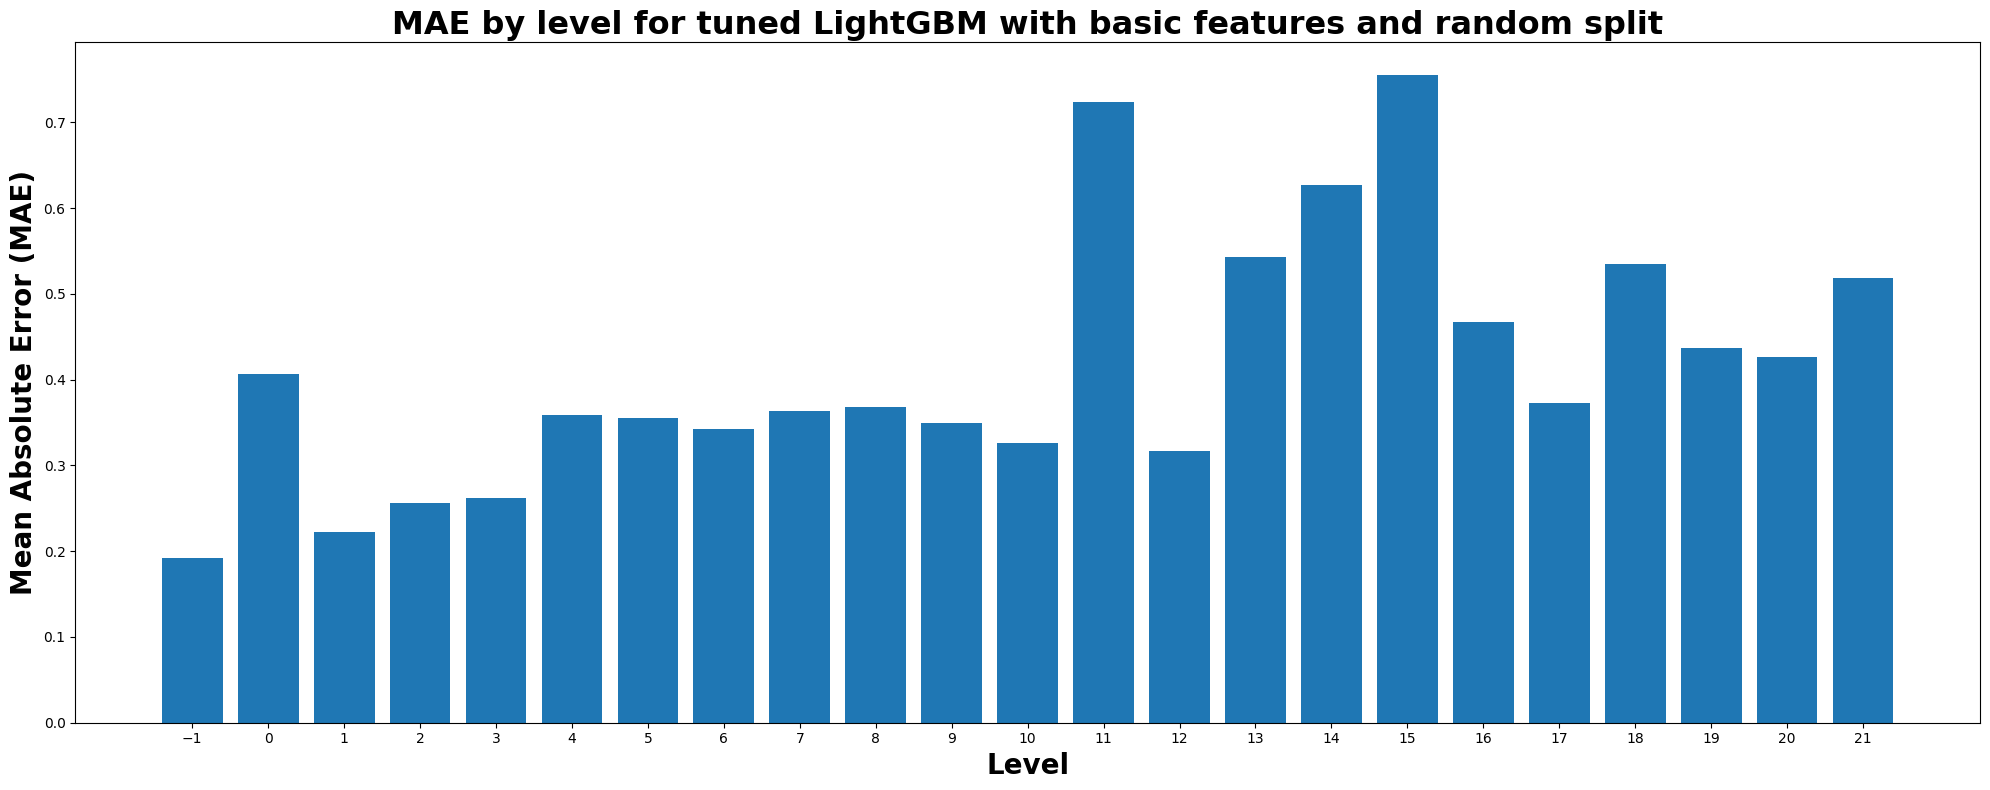

In [71]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [72]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.31

Round type: 0.5
RMSE: 0.33

Round type: 0.33
RMSE: 0.35

Round type: 0.45
RMSE: 0.33



In [88]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [89]:
results

In [90]:
from training.results import plot_summary

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,0.758611,0.447891
1,chronological,Optuna,basic,0.754996,0.459143
2,random,default,basic,0.568104,0.368391
3,random,Optuna,basic,0.567588,0.364954


In [91]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

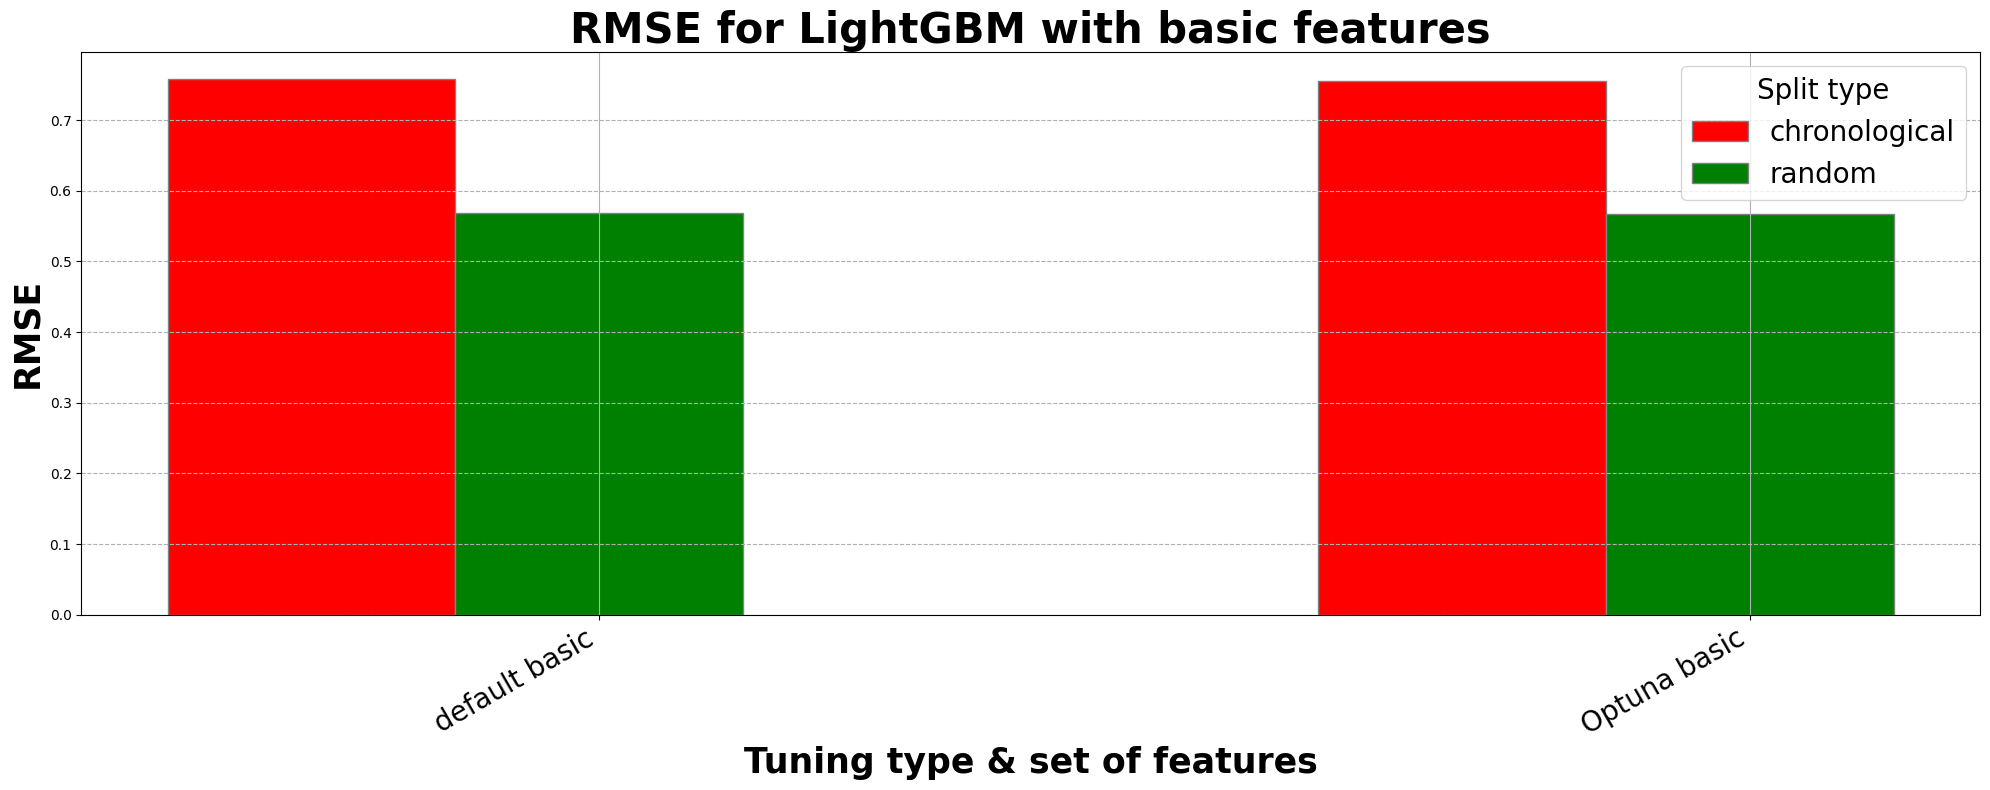

In [92]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

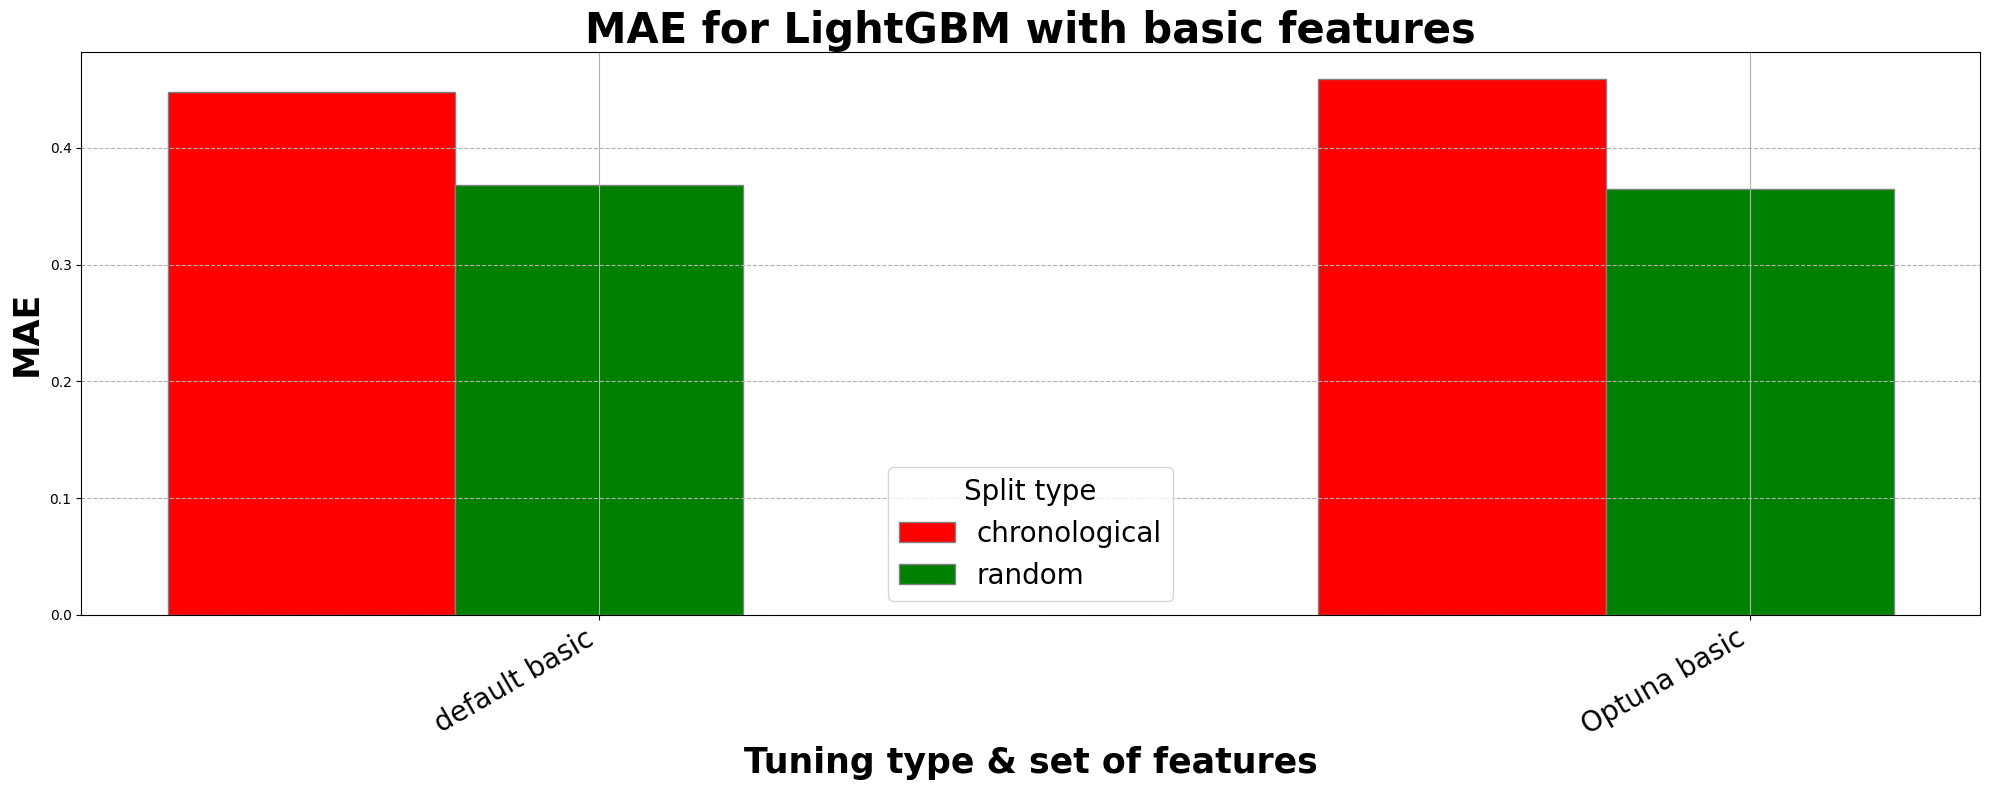

In [93]:
results.to_csv("./lightgbm_basic_results.csv")